In [22]:
'''
Unsupervised k-means clustering on standardized and cleaned plain text file versions of EEBO-TCP texts. 

Produces a user-specified number of clusters based on term frequency vectorization. 
These clusters are described using the keywords found in their corresponding entries 
in a metadata CSV file made using metadata.py in Stage I. 

The vectorize and cluster functions are adapted from the EarlyPrint Lab: 
    https://earlyprint.org/jupyterbook/unsupervised.html
The topTerms function is adapted from 
    https://pythonprogramminglanguage.com/kmeans-text-clustering/ 
The elbow and intercluster functions are adapted from Yellowbrick's documentation: 
    https://www.scikit-yb.org/en/latest/index.html
'''
import numpy as np
import pandas as pd
from collections import defaultdict,Counter
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('ggplot')


def vectorize(strings,ids,option):
    '''
    Vectorizes the texts and returns a dataframe of texts mapping to their TCP IDs. 
    '''
    # vector = TfidfVectorizer(min_df=2, sublinear_tf=True)
    # results = vector.fit_transform(strings)
    if option =='count': vector = CountVectorizer()
    else: vector = TfidfVectorizer()
    results = vector.fit_transform(strings)
    df = pd.DataFrame(results.toarray(), index=ids, columns=vector.get_feature_names()) # Convert information back to a DataFrame
    return df

def cluster(df,ids,num):
    model = KMeans(n_clusters=num) 
    model.fit(df) 
    kmeans_groups = defaultdict(list)
    for k,v in zip(model.labels_,ids):
        kmeans_groups[k].append(v)
    for k,v in kmeans_groups.items(): 
        print(k, v)
    return model

def topTerms(model,df,num):
    tops = {}
    centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = list(df.columns)
    for i in range(num):
        tops[i] = []
        for ind in centroids[i, :20]:
            tops[i].append(terms[ind])
    return tops 

def elbow(df):
    from yellowbrick.cluster.elbow import kelbow_visualizer
    kelbow_visualizer(KMeans(), df, k=(2, 10),timings=False)
    # kelbow_visualizer(KMeans(), df, k=(2, 10),metric='calinski_harabasz',timings=False)
    # kelbow_visualizer(KMeans(), df, k=(2, 10),metric='silhouette',timings=False)
    
def intercluster(model,num):
    from yellowbrick.cluster import intercluster_distance
    intercluster_distance(KMeans(num),model, embedding='mds') 


def pca(df):
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df) 
    pca_df = pd.DataFrame(pca_results, columns=["pc1","pc2"])
    pca_df.plot.scatter(x='pc1', y='pc2')
    plt.legend()
    plt.figure(figsize=(20,10))
    plt.show()

In [4]:
import os,re 


def keywords(csv):
    '''
    Returns a dictionary in this format {id : (keywords,date)}
    '''
    df = pd.read_csv(csv)
    keywords = df['keywords']
    ids = df['id']
    dates = df['date']
    numFiles = len(ids)
    count = 0
    dict = {}
    while count < numFiles:
        words = set(keywords[count].split('--'))
        # removing unnecessary keywords
        words.discard('')
        # Removing unnecessary dates  
        newWords = []
        for w in words: 
            w = w.replace('.','')
            w = re.sub(r'\([^)]*\)','',w)
            w = re.sub(r'[."\'-?:!;]', '', w)
            w = re.sub(r' ca|-|[0-9]{4}|,','',w)
            w = w.strip()
            newWords.append(w)
        newWords = set(newWords)
        newWords.discard('')
        newWords.discard('-')
        newWords.discard('th century')
        newWords.discard('I')
        newWords.discard('Early works to')
        newWords.discard('To')
        newWords.discard('No Keywords')
        newWords.discard('Great Britain')
        dict[ids[count]] = (newWords,dates[count])
        count += 1
    return dict 
    
def getTexts(folder,search):
    texts = {}
    for file in os.listdir(folder):
        if 'NOTES' not in file: 
            name = file.split('.')[0]
            if name in search: 
                path = os.path.join(folder,file)
                with open(path,'r') as file: 
                    data = file.readlines()
                if len(data) != 0: 
                    texts[name] = data[0]
    return texts

In [41]:
csv_data = pd.read_csv('/Users/amycweng/Digital Humanities/sermons.csv')
all_info = pd.read_csv('/Users/amycweng/Digital Humanities/Early-Modern-London/Relevant_Metadata/charityTCP.csv')
tcpIDs = [ _ for _ in csv_data['id']]
idToTitle = {}
for idx, title in enumerate(all_info['title']):
    curr_id = all_info['id'][idx]
    if curr_id in tcpIDs: 
        idToTitle[curr_id] = title  
textInfo = getTexts('/Users/amycweng/Digital Humanities/charityTXT',tcpIDs)
print(len(textInfo))

70


In [37]:
'''Get keywords metadata for each text in a dictionary'''
'''Create list of feature strings for each file and remove stopwords'''
import re 
features = {}
kwdict = keywords('/Users/amycweng/Digital Humanities/Early-Modern-London/Relevant_Metadata/charityTCP.csv')

for ID in tcpIDs:
    features[ID] = [textInfo[ID]]
    kWords = (list(kwdict[ID][0]))
    features[ID].append(' '.join(kWords*50))
    if '' in features[ID]: features[ID].remove('')
    featureStr = ' '.join(features[ID])
    featureStr = re.sub(r' if | of | by | yet | the | man | see | and ',' ',featureStr)
    featureStr = re.sub('  ',' ',featureStr)
    features[ID] = featureStr
print(f'Total number of texts to classify is {len(features)}')

Total number of texts to classify is 70


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


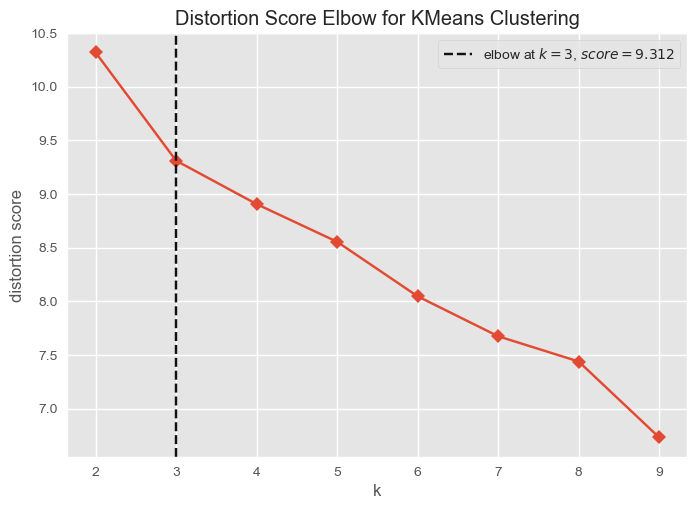

In [39]:
df = vectorize(features.values(),features.keys(),'tfidf')
elbow(df)

['The dignitie of chiualrie set forth in a sermon preached before the Artillery Company of London, Iune xiij. 1626. By', 'The saints support, set out in a sermon preached before the Honourable House of Commons assembled in Parliament. At a', 'The right vvay: or A direction for obtaining good successe in a weighty enterprise. Set out in a sermon preached', "One of the sermons preach't to the Lords of the High Court of Parliament, in their solemne fast held on", "A sermon preach't to his Maiesty, at the court of White-hall. Aug.8. / By Jos. B. of Exon.", 'A sermon of publike thanksgiuing for the wonderfull mitigation of the late mortalitie preacht before his Matie; vpon his gracious', 'An holy panegyrick a sermon preached at Paules Crosse vpon the anniuersarie solemnitie of the happie inauguration of our dread', "Mercies memorial set out in a sermon preached in Paul's church, Novemb. 17, 1644, in memoriall of the great deliverance", 'The progresse of divine providence, set out in a sermo

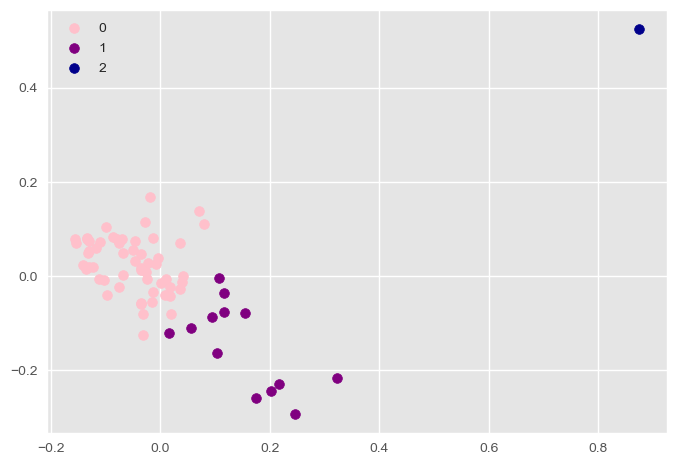

<Figure size 2000x1000 with 0 Axes>

In [44]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(df) 
pca
num = 3
model = KMeans(n_clusters=num) 
label = model.fit_predict(pca_results) 
kmeans_groups = defaultdict(list)
for k,v in zip(label,tcpIDs):
    kmeans_groups[k].append(v)
for k,v in kmeans_groups.items(): 
    if k == 1: 
        print([' '.join(idToTitle[tcpID].split(' ')[:20]) for tcpID in v])
u_labels = np.unique(label)
groupColors = {0:'pink',1:'purple',2:'darkblue',3:'plum',4:'palevioletred',5:'darkgreen'}
for i in u_labels:
    plt.scatter(pca_results[label == i , 0] , pca_results[label == i , 1] , label = i,color=groupColors[i])
plt.legend()
plt.figure(figsize=(20,10))
plt.show()

In [11]:
'''Get additional features'''
inFile = open('/srv/data/amy/allfeatures.txt','r')
inFileLines = inFile.readlines()
inFile.close()
featuresDict = {}
for line in inFileLines: 
    line = line.split(':')
    tcpID = line[0].strip()
    if tcpID in period: 
        features = line[1].strip().split(' ')
        featuresDict[tcpID] = features
print(len(featuresDict))

'''Get drug and tobacco features'''
inFile = open('/srv/data/amy/allTobaccoDrug.txt','r')
inFileLines = inFile.readlines()
inFile.close()
tobaccoDrug = {}
for line in inFileLines: 
    line = line.split(':')
    tcpID = line[0].strip()
    if tcpID in period: 
        features = line[1].strip().split(' ')
        tobaccoDrug[line[0].strip()] = features
print(len(tobaccoDrug))

'''Get tobacco n-gram features'''
inFile = open('/srv/data/amy/allopiumgrams.txt','r')
inFileLines = inFile.readlines()
inFile.close()
tobaccoNgrams = {}
for line in inFileLines: 
    line = line.split(':')
    tcpID = line[0].strip()
    if tcpID in period: 
        features = line[1].strip()
        if features == '': continue
        tobaccoNgrams[line[0].strip()] = features.strip()
print(len(tobaccoNgrams))

43
43
43
